### Notes 
1. Importing Spreadsheets or CSV files (QGIS3) - https://www.qgistutorials.com/en/docs/3/importing_spreadsheets_csv.html
2. Nearest Neighbor Analysis (QGIS3) - https://www.qgistutorials.com/en/docs/3/nearest_neighbor_analysis.html
3. Getting list of coordinates (lat,long) from OSMNX Geoseries - https://copyprogramming.com/howto/plotting-a-route-with-osmnx
4. QNEAT3 Algorithms - https://root676.github.io/OdMatrixAlgs
5. Source Paper - https://www.researchgate.net/publication/319291962_The_Traditional_Four_Steps_Transportation_Modeling_Using_Simplified_Transport_Network_A_Case_Study_of_Dhaka_City_Bangladesh

In [1]:
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt

### Steps in Generating Demand Matrix

#### 1. Determine barangay centroids - data from philatlas.com (filename: sample_barangay_centroids.csv)

In [2]:
barangay_centroids = pd.read_csv("sample_barangay_centroids.csv")
barangay_centroids.head()

,Barangay Name,Latitude,Longitude
0,Barangka,14.6327,121.0821
1,Calumpang,14.6238,121.0928
2,Concepcion Dos,14.6386,121.1117
3,Concepcion Uno,14.6497,121.1020
4,Fortune,14.6632,121.1274


#### 2. Import barangay centroids to QGIS

The bus stops are colored blue, while the barangay centroids are colored pink.

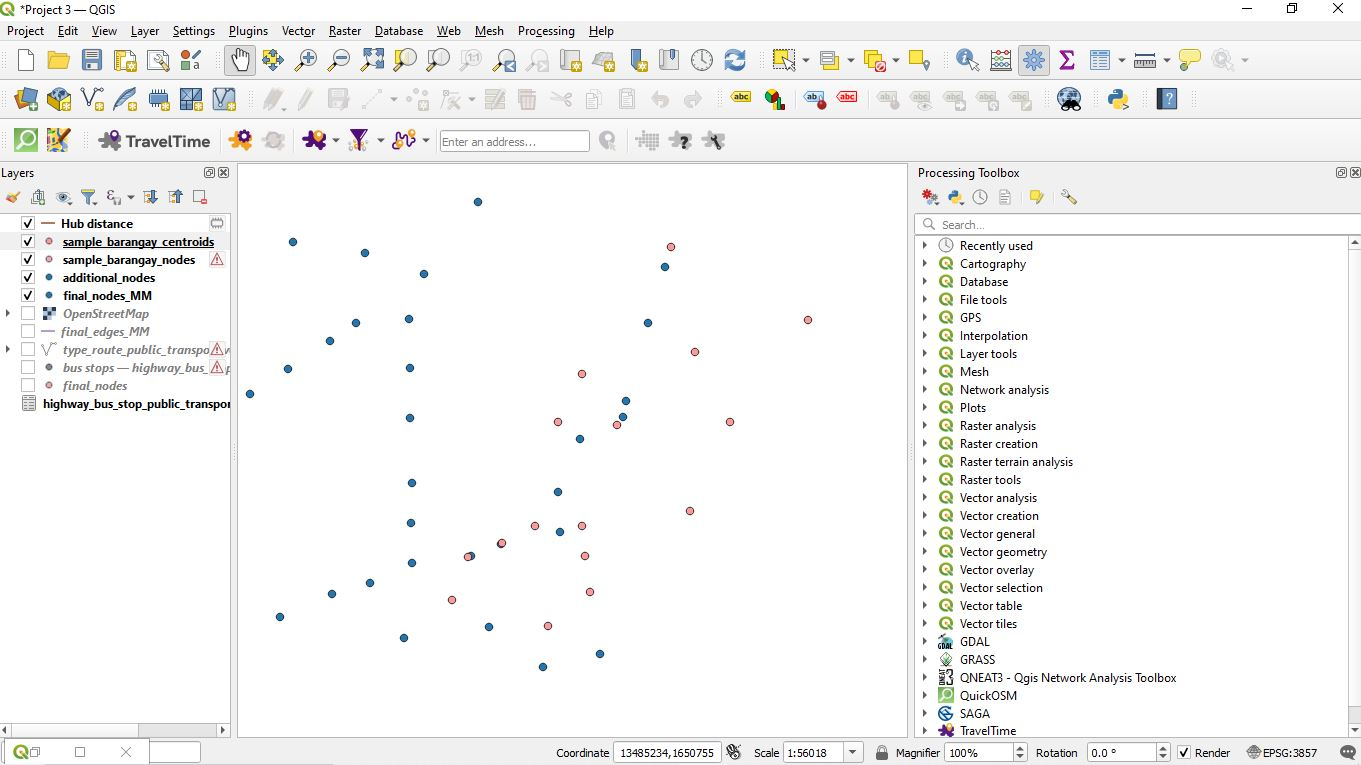

In [3]:
from IPython.display import Image

Image(filename='Capture1.jpg') 

#### 3. Using Nearest Neighbor Analysis in QGIS, determine the nearest bus stop node (filename: sample_barangay_centroids_to_nearest_node.csv)

Processing -> Toolbox -> Vector Analysis -> Distance to nearest hub (line to hub)

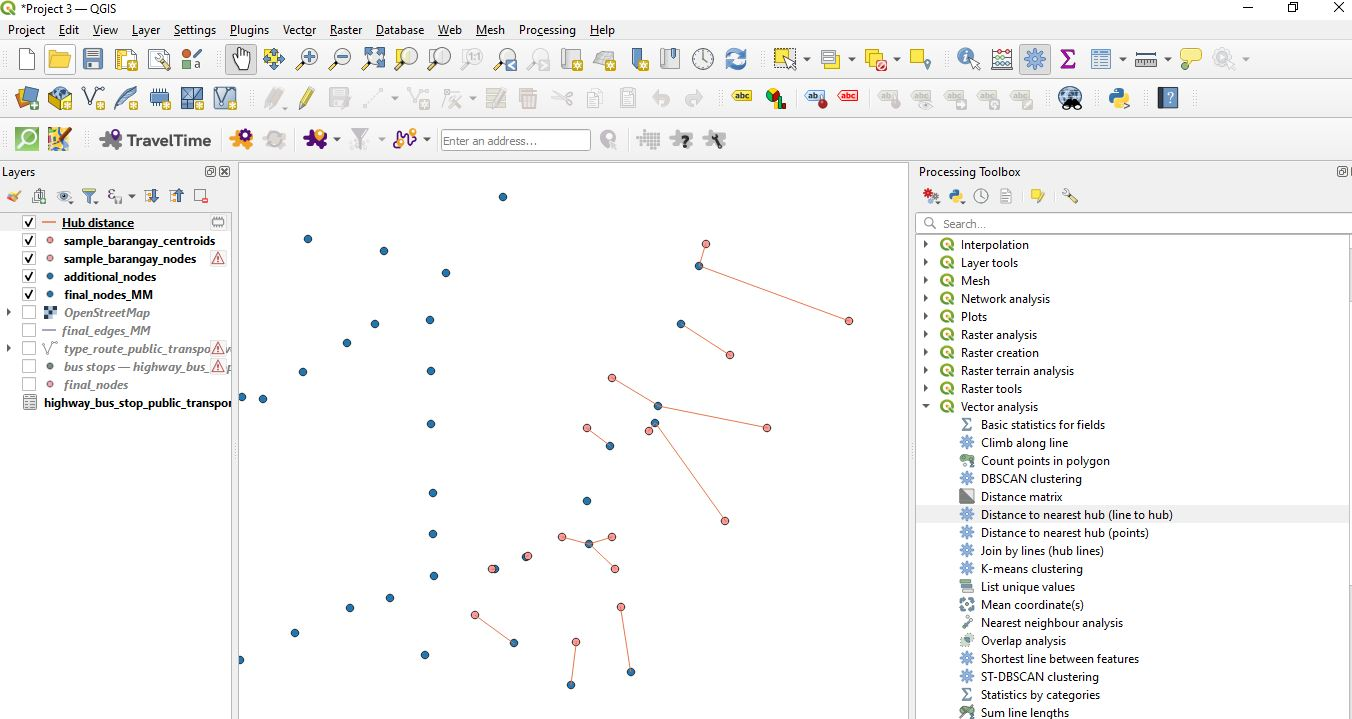

In [4]:
Image(filename='Capture2.jpg') 

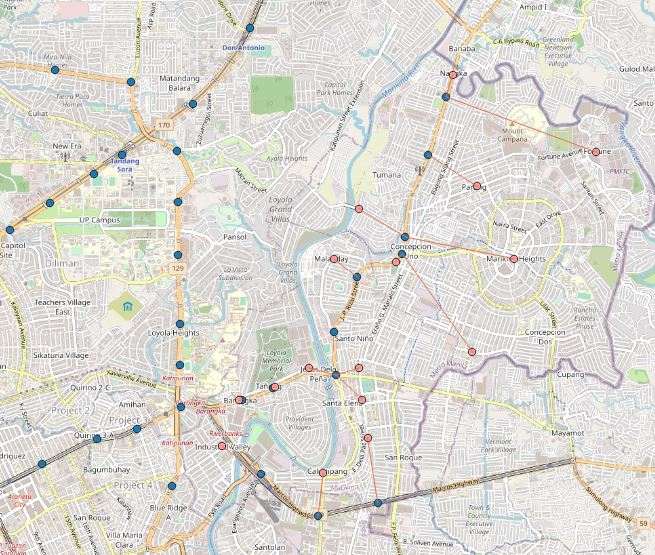

In [5]:
Image(filename='Capture3.jpg') 

In [6]:
# CSV File generated from QGIS
df_centroids_to_node = pd.read_csv("sample_barangay_centroids_to_nearest_node.csv")
df_centroids_to_node

,Barangay Name,Latitude,Longitude,HubName,HubDist
0,San Roque,14.6281,121.0984,Sta. Lucia Grandmall,887.738349
1,Concepcion Dos,14.6386,121.1117,Bayan Bayanan,1643.764433
2,Calumpang,14.6238,121.0928,Ligaya,589.734951
3,Barangka,14.6327,121.0821,Riverbanks,42.368185
4,Jesus de La Pena,14.6367,121.0910,Marikina Bayan,376.194021
5,Tumana,14.6562,121.0973,Tumana,738.476926
6,Industrial Valley,14.6271,121.0800,SM Marikina,654.151655
7,Fortune,14.6632,121.1274,Nangka,2179.422345
8,Concepcion Uno,14.6497,121.1020,Bayan Bayanan,135.879562
9,Parang,14.6590,121.1123,Fairlane,790.369050


In [7]:
# For sample only, will delete later
df_centroids_to_node.drop(index=[6], inplace=True)
df_centroids_to_node

,Barangay Name,Latitude,Longitude,HubName,HubDist
0,San Roque,14.6281,121.0984,Sta. Lucia Grandmall,887.738349
1,Concepcion Dos,14.6386,121.1117,Bayan Bayanan,1643.764433
2,Calumpang,14.6238,121.0928,Ligaya,589.734951
3,Barangka,14.6327,121.0821,Riverbanks,42.368185
4,Jesus de La Pena,14.6367,121.0910,Marikina Bayan,376.194021
5,Tumana,14.6562,121.0973,Tumana,738.476926
7,Fortune,14.6632,121.1274,Nangka,2179.422345
8,Concepcion Uno,14.6497,121.1020,Bayan Bayanan,135.879562
9,Parang,14.6590,121.1123,Fairlane,790.369050
10,Nangka,14.6726,121.1092,Nangka,303.924945


#### 4. Centroids to Corresponding Node

In [8]:
df_cn = df_centroids_to_node[["Barangay Name","HubName"]]
df_cn.set_index('Barangay Name', inplace=True)
nodes = list(df_cn["HubName"].unique())
centroids = list(df_cn.index)
df_cn_final = pd.DataFrame(nodes, columns=["Node"])

list_all = []
for node in nodes:
    list_c = []
    for centroid in centroids:
        a = df_cn.loc[centroid] == node
        if a.iloc[0]:
            list_c.append(centroid)
    list_all.append(list_c)
    
df_cn_final["Centroids"] = list_all
df_cn_final.set_index("Node", inplace=True)
df_cn_final

,Centroids
Node,
Sta. Lucia Grandmall,[San Roque]
Bayan Bayanan,"[Concepcion Dos, Concepcion Uno]"
Ligaya,[Calumpang]
Riverbanks,[Barangka]
Marikina Bayan,"[Jesus de La Pena, Santo Nino, Santa Elena]"
Tumana,"[Tumana, Marikina Heights]"
Nangka,"[Fortune, Nangka]"
Fairlane,[Parang]
Golden Valley,[Malanday]


#### 5. Solve for Trip Attraction Using OSMNX GeoSeries (nodes for amenity, landuse, shop)

In [9]:
def node_ID_to_coordinates(node_ID, G):
    x = G.nodes[node_ID]['x'] 
    y = G.nodes[node_ID]['y']
    return x,y

In [10]:
def feature_nodes(place, place_x, place_y, plot_features=False):

    # Get nodes surrounding a place
    #ox.config(use_cache=True, log_console=True)
    ox.settings.use_cache=True
    ox.settings.log_console=True
    
    G = ox.graph_from_place(place, network_type='drive')
    #tags = {'amenity' : ['hospital','university','social_facility','cafe','fast_food','restaurant','college','research_institute','bank','veterinary'],
    #        'landuse' : ['retail','commercial','education','residential','cemetery'],
    #        'shop' : ['water','bakery','department_store','general','mall','supermarket']}
    
    tags_amenity = {'amenity' : ['hospital','university','social_facility','cafe','fast_food','restaurant','college','research_institute','bank','veterinary']}
    tags_landuse = {'landuse' : ['retail','commercial','education','residential','cemetery']}
    tags_shop = {'shop' : ['water','bakery','department_store','general','mall','supermarket']}

    tags = [tags_amenity, tags_landuse, tags_shop]

    # Initialization
    no_of_feature_nodes = []
    nn_all = []

    for tag in tags:
        gdf = ox.features_from_place(place, tag)
        #gdf["geometry"].to_crs(epsg=4326)
        centroids = gdf.centroid
        X = centroids.x
        Y = centroids.y
        nn = ox.nearest_nodes(G, X, Y)
        no_of_feature_nodes.append(len(nn))
        
        for n in nn:
            nn_all.append(n)

    if plot_features:
        # Plot these nodes
        plt.rcParams["figure.figsize"] = [4,6]
        plt.rcParams["figure.autolayout"] = True
        plt.xlim(120.90, 121.15)
        plt.ylim(14.35, 14.80)

        feature_df = pd.DataFrame(nn_all, columns=["node_id"])
        # initialize
        feature_node_IDs = []
        feature_node_coordinates = []
    
        for node in nn_all:
            x,y = node_ID_to_coordinates(node, G)
            # store the list of coordinates of new nodes
            zipxy = lambda a,b:(a,b)
            c = zipxy(x,y)
            feature_node_coordinates.append(c)
            # plot/visualize the raster nodes
            plt.plot(x, y, marker="o", markersize=1, markeredgecolor="green", markerfacecolor="green")

        plt.plot(place_x, place_y, marker="o", markersize=2, markeredgecolor="pink", markerfacecolor="pink")
        feature_df["coordinates"] = feature_node_coordinates
        plt.show()

    return no_of_feature_nodes

C:\Users\Sheena\AppData\Local\Temp\ipykernel_16260\1562307363.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.centroid
C:\Users\Sheena\AppData\Local\Temp\ipykernel_16260\1562307363.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.centroid
C:\Users\Sheena\AppData\Local\Temp\ipykernel_16260\1562307363.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.centroid


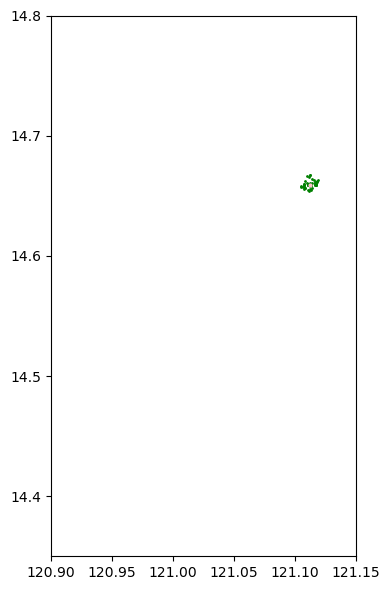

[13, 35, 13]

In [11]:
place = 'Parang, Marikina, Metro Manila, Philippines'
place_x = 121.1123
place_y = 14.6590
no_of_feature_nodes = feature_nodes(place, place_x, place_y, plot_features=True)
no_of_feature_nodes

In [12]:
df_cf = pd.DataFrame(centroids, columns=["Centroid"])
df_cf[["Latitude","Longitude"]] = df_centroids_to_node[["Latitude","Longitude"]]
df_cf.set_index("Centroid", inplace=True)
df_cf.head()

,Latitude,Longitude
Centroid,,
San Roque,14.6281,121.0984
Concepcion Dos,14.6386,121.1117
Calumpang,14.6238,121.0928
Barangka,14.6327,121.0821
Jesus de La Pena,14.6367,121.0910


In [13]:
list_fc = []
for centroid in centroids:
    place = centroid + ', Marikina, Metro Manila, Philippines'
    place_x = df_cf["Longitude"][centroid]
    place_y = df_cf["Latitude"][centroid]
    no_of_feature_nodes = feature_nodes(place, place_x, place_y, plot_features=False)
    list_fc.append(no_of_feature_nodes)

df_cf["No_of_Features"] = list_fc
df_cf

C:\Users\Sheena\AppData\Local\Temp\ipykernel_16260\1562307363.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.centroid
C:\Users\Sheena\AppData\Local\Temp\ipykernel_16260\1562307363.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.centroid
C:\Users\Sheena\AppData\Local\Temp\ipykernel_16260\1562307363.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.centroid
C:\Users\Sheena\AppData\Local\Temp\ipykernel_16260\1562307363.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorre

,Latitude,Longitude,No_of_Features
Centroid,,,
San Roque,14.6281,121.0984,"[64, 12, 13]"
Concepcion Dos,14.6386,121.1117,"[64, 26, 8]"
Calumpang,14.6238,121.0928,"[38, 11, 7]"
Barangka,14.6327,121.0821,"[23, 13, 6]"
Jesus de La Pena,14.6367,121.0910,"[1, 5, 3]"
Tumana,14.6562,121.0973,"[1, 14, 1]"
Fortune,NaN,NaN,"[2, 41, 1]"
Concepcion Uno,14.6632,121.1274,"[72, 60, 18]"
Parang,14.6497,121.1020,"[13, 35, 13]"


In [14]:
df_attraction = df_cf.drop(columns=["Latitude","Longitude"])
df_attraction.head()

,No_of_Features
Centroid,
San Roque,"[64, 12, 13]"
Concepcion Dos,"[64, 26, 8]"
Calumpang,"[38, 11, 7]"
Barangka,"[23, 13, 6]"
Jesus de La Pena,"[1, 5, 3]"


#### df_attraction

In [15]:
# amenity, land_use, shop
attraction_constant = [50, 40, 20]
trip_rate = 0.50

list_attraction = []
for centroid in centroids:
    am = df_attraction["No_of_Features"][centroid][0]
    la = df_attraction["No_of_Features"][centroid][1]
    sh = df_attraction["No_of_Features"][centroid][2]
    attraction = int(((am*attraction_constant[0]) + (la*attraction_constant[1]) + (sh*attraction_constant[2])) * trip_rate)
    list_attraction.append(attraction)

df_attraction["Trip_Attraction"] = list_attraction
df_attraction.drop(columns="No_of_Features", inplace=True)
df_attraction.head()

,Trip_Attraction
Centroid,
San Roque,1970
Concepcion Dos,2200
Calumpang,1240
Barangka,895
Jesus de La Pena,155


#### 6. Solve for Trip Generation using Demographics from philatlas

In [16]:
# import csv file

df_gen = pd.read_csv("demographics-from-philatlas.csv")
df_gen.rename(columns={'Barangay':'Centroid'}, inplace=True)
df_gen.set_index("Centroid", inplace=True)
df_gen.head()

,2020,2015_cat1,2015_cat2,2015_cat3,2015_cat1%,2015_cat2%,2015_cat3%
Centroid,,,,,,,
Barangka,"16,639","4,664","12,860",980,25.21,69.50,5.30
Calumpang,"15,602","3,741","10,303",813,25.18,69.35,5.47
Concepcion Dos,"24,023","5,351","17,851","2,435",20.87,69.63,9.50
Concepcion Uno,"44,683","10,762","29,413","2,389",25.28,69.10,5.61
Fortune,"38,624","11,506","23,419","1,217",31.84,64.80,3.37


In [17]:
generation_constant = [0.2, 0.5, 0.1]
list_gen = []
gen_centroids = df_gen.index

for c in gen_centroids:
    totalp = int(df_gen["2020"][c].replace(",",""))
    cat1p = df_gen["2015_cat1%"][c]
    cat2p = df_gen["2015_cat2%"][c]
    cat3p = df_gen["2015_cat3%"][c]
    generation = int((generation_constant[0]*0.01*cat1p*totalp) + (generation_constant[1]*0.01*cat2p*totalp) + (generation_constant[2]*0.01*cat3p*totalp))
    list_gen.append(generation)

df_gen["Trip_Generation"] = list_gen
df_gen

,2020,2015_cat1,2015_cat2,2015_cat3,2015_cat1%,2015_cat2%,2015_cat3%,Trip_Generation
Centroid,,,,,,,,
Barangka,"16,639","4,664","12,860",980,25.21,69.50,5.30,6709
Calumpang,"15,602","3,741","10,303",813,25.18,69.35,5.47,6281
Concepcion Dos,"24,023","5,351","17,851","2,435",20.87,69.63,9.50,9594
Concepcion Uno,"44,683","10,762","29,413","2,389",25.28,69.10,5.61,17947
Fortune,"38,624","11,506","23,419","1,217",31.84,64.80,3.37,15103
Jesus de La Pena,"10,201","2,480","7,140",555,24.37,70.17,5.45,4131
Malanday,"53,886","16,420","36,867","2,155",29.62,66.50,3.89,21318
Marikina Heights,"42,761","10,102","26,640","2,053",26.04,68.67,5.29,17135
Nangka,"43,368","12,796","29,126","1,906",29.20,66.46,4.35,17132


#### df_generation

In [18]:
df_generation = df_gen.drop(columns=["2020","2015_cat1","2015_cat2","2015_cat3","2015_cat1%","2015_cat2%","2015_cat3%"])
df_generation.head()

,Trip_Generation
Centroid,
Barangka,6709
Calumpang,6281
Concepcion Dos,9594
Concepcion Uno,17947
Fortune,15103


#### 7. Centroids: Trip_Generation and Trip_Attraction

In [19]:
df_generation_attraction = pd.concat([df_generation, df_attraction], axis=1)
df_generation_attraction

,Trip_Generation,Trip_Attraction
Centroid,,
Barangka,6709,895
Calumpang,6281,1240
Concepcion Dos,9594,2200
Concepcion Uno,17947,3180
Fortune,15103,880
Jesus de La Pena,4131,155
Malanday,21318,590
Marikina Heights,17135,2815
Nangka,17132,840


In [20]:
centroids_list = df_cn_final["Centroids"].to_list()
# Initialization
list_gen_cen = []
list_att_cen = []
for centroid in centroids_list:
    list_gen = []
    list_att = []
    for barangay in centroid:
        gen = df_generation_attraction["Trip_Generation"][barangay]
        list_gen.append(gen)
        att = df_generation_attraction["Trip_Attraction"][barangay]
        list_att.append(att)
    list_gen_cen.append(list_gen)
    list_att_cen.append(list_att)
df_cn_final["List_Trip_Generation"] = list_gen_cen
df_cn_final["List_Trip_Attraction"] = list_att_cen

trip_gen_list = df_cn_final["List_Trip_Generation"].to_list()
trip_att_list = df_cn_final["List_Trip_Attraction"].to_list()
# Initialization
list_gen_sum = []
list_att_sum = []
for trip_gen in trip_gen_list:
    gen_sum = sum(trip_gen)
    list_gen_sum.append(gen_sum)
for trip_att in trip_att_list:
    att_sum = sum(trip_att)
    list_att_sum.append(att_sum)

df_cn_final["Trip_Generation"] = list_gen_sum
df_cn_final["Trip_Attraction"] = list_att_sum
df_cn_final.drop(columns=["List_Trip_Generation","List_Trip_Attraction"], inplace=True)
df_cn_final

,Centroids,Trip_Generation,Trip_Attraction
Node,,,
Sta. Lucia Grandmall,[San Roque],6853,1970
Bayan Bayanan,"[Concepcion Dos, Concepcion Uno]",27541,5380
Ligaya,[Calumpang],6281,1240
Riverbanks,[Barangka],6709,895
Marikina Bayan,"[Jesus de La Pena, Santo Nino, Santa Elena]",18687,4815
Tumana,"[Tumana, Marikina Heights]",35863,3130
Nangka,"[Fortune, Nangka]",32235,1720
Fairlane,[Parang],16039,1155
Golden Valley,[Malanday],21318,590


#### 8.1 Trip Distribution

In [21]:
# TENTATIVE (for sample only)
list_nodes = list(df_cn_final.index)
no_of_nodes = len(list_nodes)
list_node_numbers = range(0,no_of_nodes)
list_elements = [0] * no_of_nodes

df_trip_distribution = pd.DataFrame(df_cn_final["Trip_Generation"], index=df_cn_final.index)
for node in list_nodes:
    df_trip_distribution[node] = [0] * no_of_nodes

df_trip_distribution.loc[len(df_trip_distribution.index)] = [0] + df_cn_final["Trip_Attraction"].to_list()

# CHANGE the dictionary key below (len(df_trip_distribution.index))
df_trip_distribution.rename(index={10:'Trip_Attraction'},inplace=True)
df_trip_distribution

,Trip_Generation,Sta. Lucia Grandmall,Bayan Bayanan,Ligaya,Riverbanks,Marikina Bayan,Tumana,Nangka,Fairlane,Golden Valley,Tanong
Node,,,,,,,,,,,
Sta. Lucia Grandmall,6853,0,0,0,0,0,0,0,0,0,0
Bayan Bayanan,27541,0,0,0,0,0,0,0,0,0,0
Ligaya,6281,0,0,0,0,0,0,0,0,0,0
Riverbanks,6709,0,0,0,0,0,0,0,0,0,0
Marikina Bayan,18687,0,0,0,0,0,0,0,0,0,0
Tumana,35863,0,0,0,0,0,0,0,0,0,0
Nangka,32235,0,0,0,0,0,0,0,0,0,0
Fairlane,16039,0,0,0,0,0,0,0,0,0,0
Golden Valley,21318,0,0,0,0,0,0,0,0,0,0


In [22]:
print(sum(list(df_trip_distribution["Trip_Generation"])))
print(sum(list(df_cn_final["Trip_Generation"])))

175063
175063


In [23]:
# Solve for adjustment_factor
total_trip_generation = sum(list(df_trip_distribution["Trip_Generation"]))
total_trip_attraction = sum(list(df_cn_final["Trip_Attraction"]))
adjustment_factor = round(total_trip_generation/total_trip_attraction,4)
adjustment_factor

8.2054

In [24]:
# Adjusted total trip attraction
original_trip_attraction_list = df_trip_distribution.loc["Trip_Attraction"].to_list()
adjusted_trip_attraction_list = []

for e in original_trip_attraction_list:
    adjusted_trip_attraction_list.append(int(e*adjustment_factor))

print(original_trip_attraction_list)
print(adjusted_trip_attraction_list)
print(total_trip_generation)
print(sum(adjusted_trip_attraction_list))

[0, 1970, 5380, 1240, 895, 4815, 3130, 1720, 1155, 590, 440]
[0, 16164, 44145, 10174, 7343, 39509, 25682, 14113, 9477, 4841, 3610]
175063
175058


In [25]:
df_trip_distribution.loc[len(df_trip_distribution.index)] = adjusted_trip_attraction_list

# CHANGE the dictionary key below (len(df_trip_distribution.index))
df_trip_distribution.rename(index={11:'Adjusted_Trip_Attraction'},inplace=True)
df_trip_distribution

,Trip_Generation,Sta. Lucia Grandmall,Bayan Bayanan,Ligaya,Riverbanks,Marikina Bayan,Tumana,Nangka,Fairlane,Golden Valley,Tanong
Node,,,,,,,,,,,
Sta. Lucia Grandmall,6853,0,0,0,0,0,0,0,0,0,0
Bayan Bayanan,27541,0,0,0,0,0,0,0,0,0,0
Ligaya,6281,0,0,0,0,0,0,0,0,0,0
Riverbanks,6709,0,0,0,0,0,0,0,0,0,0
Marikina Bayan,18687,0,0,0,0,0,0,0,0,0,0
Tumana,35863,0,0,0,0,0,0,0,0,0,0
Nangka,32235,0,0,0,0,0,0,0,0,0,0
Fairlane,16039,0,0,0,0,0,0,0,0,0,0
Golden Valley,21318,0,0,0,0,0,0,0,0,0,0


In [26]:
df_trip_distribution.drop(index=["Trip_Attraction"], inplace=True)

In [27]:
df_trip_distribution

,Trip_Generation,Sta. Lucia Grandmall,Bayan Bayanan,Ligaya,Riverbanks,Marikina Bayan,Tumana,Nangka,Fairlane,Golden Valley,Tanong
Node,,,,,,,,,,,
Sta. Lucia Grandmall,6853,0,0,0,0,0,0,0,0,0,0
Bayan Bayanan,27541,0,0,0,0,0,0,0,0,0,0
Ligaya,6281,0,0,0,0,0,0,0,0,0,0
Riverbanks,6709,0,0,0,0,0,0,0,0,0,0
Marikina Bayan,18687,0,0,0,0,0,0,0,0,0,0
Tumana,35863,0,0,0,0,0,0,0,0,0,0
Nangka,32235,0,0,0,0,0,0,0,0,0,0
Fairlane,16039,0,0,0,0,0,0,0,0,0,0
Golden Valley,21318,0,0,0,0,0,0,0,0,0,0


#### 8.2 Centroid: Cost Matrix Table (in terms of time) using QGIS
Network Type: https://www.qgistutorials.com/en/docs/3/downloading_osm_data.html

Vector -> QuickOSM -> QuickOSM dialog box

Processing -> Toolbox -> QNEAT3 -> Distance Matrices -> OD-Matrix From Points as Table (n:n)

input: sample_barangay_centroids.xlsx, output: cost_matrix.csv

total_cost output is the distance with the fastest time

In [28]:
csv_cost_matrix = pd.read_csv("bus_cost_matrix.csv")
csv_cost_matrix.head()

,origin_id,destination_id,entry_cost,network_cost,exit_cost,total_cost
0,Barangka,Barangka,0.000000,0.000000,0.000000,0.000000
1,Barangka,Calumpang,0.000016,3216.298944,0.000454,3216.299414
2,Barangka,Concepcion Dos,0.000016,5861.484544,0.003020,5861.487580
3,Barangka,Concepcion Uno,0.000016,3447.175599,0.000032,3447.175646
4,Barangka,Fortune,0.000016,5929.364535,0.009198,5929.373749


In [29]:
# Convert to a Matrix
df_cost_matrix = csv_cost_matrix.drop(columns=["entry_cost","network_cost","exit_cost"])
df_cost_matrix.head()

,origin_id,destination_id,total_cost
0,Barangka,Barangka,0.000000
1,Barangka,Calumpang,3216.299414
2,Barangka,Concepcion Dos,5861.487580
3,Barangka,Concepcion Uno,3447.175646
4,Barangka,Fortune,5929.373749


In [30]:
# assign centroid to a centroid_number
list_cen = df_cost_matrix["origin_id"].unique()
df_cen_no = pd.DataFrame(list_cen, columns=["Centroid"])
cen_no = list(range(0,len(list_cen)))
df_cen_no["Number"] = cen_no
df_cen_no.set_index("Centroid", inplace=True)
df_cen_no.head()

,Number
Centroid,
Barangka,0
Calumpang,1
Concepcion Dos,2
Concepcion Uno,3
Fortune,4


In [31]:
def cen_number(centroid):
    number = df_cen_no["Number"][centroid]
    return number

In [32]:
df_cost_matrix["origin_id"] = df_cost_matrix["origin_id"].apply(cen_number)
df_cost_matrix["destination_id"] = df_cost_matrix["destination_id"].apply(cen_number)

In [33]:
df_cost_matrix.head()

,origin_id,destination_id,total_cost
0,0,0,0.000000
1,0,1,3216.299414
2,0,2,5861.487580
3,0,3,3447.175646
4,0,4,5929.373749


In [34]:
rows = df_cost_matrix["origin_id"].nunique()
cols = rows
 
cost_mat = [[0 for _ in range(cols)] for _ in range(rows)]

for a in range(0, len(df_cost_matrix)):
    i = df_cost_matrix["origin_id"][a]
    j = df_cost_matrix["destination_id"][a]
    cost_mat[i][j] = df_cost_matrix["total_cost"][a]

print(f'matrix of dimension {rows} x {cols} is {cost_mat}')

matrix of dimension 15 x 15 is [[0.0, 3216.2994136, 5861.4875803, 3447.1756463, 5929.3737488, 1036.4434799, 2896.572854, 4849.6456005, 6132.3279255, 5208.3365261, 2644.0540638, 2053.656446, 1713.7822483, 531.6994438, 4106.415622], [3216.2994136, 0.0, 6253.5320417, 3839.2201078, 6321.4182102, 2179.8569547, 3288.6173155, 5241.690062, 6524.372387, 5600.3809875, 886.1458906, 1486.4232269, 1816.4183854, 2684.6000048, 4498.4600835], [5861.4875803, 6253.5320417, 0.0, 2414.3119981, 4597.9158201, 4825.0451213, 2964.921968, 1011.8519305, 4800.8699968, 3876.8785974, 5681.2866919, 5090.8890741, 4751.0148764, 5329.7881715, 2774.9576934], [3447.1756463, 3839.2201078, 2414.3119981, 0.0, 2482.1981666, 2410.7331874, 550.6100341, 1402.4700183, 2685.1523433, 1761.1609439, 3266.9747579, 2676.5771402, 2336.7029425, 2915.4762375, 659.2400398], [5929.3737488, 6321.4182102, 4597.9158201, 2482.1981666, 0.0, 4892.9312899, 3032.8081365, 3586.0738404, 3725.5913484, 721.0372662, 5749.1728604, 5158.7752426, 4818.90

In [35]:
df_cost_mat = pd.DataFrame(cost_mat)
df_cost_mat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000000,3216.299414,5861.487580,3447.175646,5929.373749,1036.443480,2896.572854,4849.645601,6132.327925,5208.336526,2644.054064,2053.656446,1713.782248,531.699444,4106.415622
1,3216.299414,0.000000,6253.532042,3839.220108,6321.418210,2179.856955,3288.617316,5241.690062,6524.372387,5600.380987,886.145891,1486.423227,1816.418385,2684.600005,4498.460084
2,5861.487580,6253.532042,0.000000,2414.311998,4597.915820,4825.045121,2964.921968,1011.851930,4800.869997,3876.878597,5681.286692,5090.889074,4751.014876,5329.788172,2774.957693
3,3447.175646,3839.220108,2414.311998,0.000000,2482.198167,2410.733187,550.610034,1402.470018,2685.152343,1761.160944,3266.974758,2676.577140,2336.702943,2915.476238,659.240040
4,5929.373749,6321.418210,4597.915820,2482.198167,0.000000,4892.931290,3032.808136,3586.073840,3725.591348,721.037266,5749.172860,5158.775243,4818.901045,5397.674340,1822.970290
5,1036.443480,2179.856955,4825.045121,2410.733187,4892.931290,0.000000,1860.130395,3813.203142,5095.885467,4171.894067,1607.611605,1017.213987,677.339789,504.744071,3069.973163
6,2896.572854,3288.617316,2964.921968,550.610034,3032.808136,1860.130395,0.000000,1953.079988,3235.762313,2311.770914,2716.371966,2125.974348,1786.100150,2364.873445,1209.850010
7,4849.645601,5241.690062,1011.851930,1402.470018,3586.073840,3813.203142,1953.079988,0.000000,3789.028017,2865.036618,4669.444712,4079.047094,3739.172897,4317.946192,1763.115714
8,6132.327925,6524.372387,4800.869997,2685.152343,3725.591348,5095.885467,3235.762313,3789.028017,0.000000,3004.554126,5952.127037,5361.729419,5021.855222,5600.628517,2025.924466
9,5208.336526,5600.380987,3876.878597,1761.160944,721.037266,4171.894067,2311.770914,2865.036618,3004.554126,0.000000,5028.135638,4437.738020,4097.863822,4676.637117,1101.933067


In [36]:
#for g in range(0, len(df_cost_mat)):
#    df_cost_mat.loc[g,g] = 300

#df_cost_mat

In [37]:
# Convert from total_cost (distance) to minute

def cost_to_min(cost):
    fixed_rate = 25    # kph
    cost = cost/1000   # convert to km
    min = (cost/fixed_rate)*60
    return min

df_cost_mat = pd.DataFrame(df_cost_mat.apply(cost_to_min))
df_cost_mat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000000,7.719119,14.067570,8.273222,14.230497,2.487464,6.951775,11.639149,14.717587,12.500008,6.345730,4.928775,4.113077,1.276079,9.855397
1,7.719119,0.000000,15.008477,9.214128,15.171404,5.231657,7.892682,12.580056,15.658494,13.440914,2.126750,3.567416,4.359404,6.443040,10.796304
2,14.067570,15.008477,0.000000,5.794349,11.034998,11.580108,7.115813,2.428445,11.522088,9.304509,13.635088,12.218134,11.402436,12.791492,6.659898
3,8.273222,9.214128,5.794349,0.000000,5.957276,5.785760,1.321464,3.365928,6.444366,4.226786,7.840739,6.423785,5.608087,6.997143,1.582176
4,14.230497,15.171404,11.034998,5.957276,0.000000,11.743035,7.278740,8.606577,8.941419,1.730489,13.798015,12.381061,11.565363,12.954418,4.375129
5,2.487464,5.231657,11.580108,5.785760,11.743035,0.000000,4.464313,9.151688,12.230125,10.012546,3.858268,2.441314,1.625615,1.211386,7.367936
6,6.951775,7.892682,7.115813,1.321464,7.278740,4.464313,0.000000,4.687392,7.765830,5.548250,6.519293,5.102338,4.286640,5.675696,2.903640
7,11.639149,12.580056,2.428445,3.365928,8.606577,9.151688,4.687392,0.000000,9.093667,6.876088,11.206667,9.789713,8.974015,10.363071,4.231478
8,14.717587,15.658494,11.522088,6.444366,8.941419,12.230125,7.765830,9.093667,0.000000,7.210930,14.285105,12.868151,12.052453,13.441508,4.862219
9,12.500008,13.440914,9.304509,4.226786,1.730489,10.012546,5.548250,6.876088,7.210930,0.000000,12.067526,10.650571,9.834873,11.223929,2.644639


In [38]:
df_cost = df_cn_final["Centroids"].to_frame()
list_c = df_cost["Centroids"].to_list()

list_cn = []
for c in list_c:
    ccn = []
    for d in c:
        cn = cen_number(d)
        ccn.append(cn)
    list_cn.append(ccn)
        
df_cost["Centroid_Numbers"] = list_cn
df_cost

,Centroids,Centroid_Numbers
Node,,
Sta. Lucia Grandmall,[San Roque],[10]
Bayan Bayanan,"[Concepcion Dos, Concepcion Uno]","[2, 3]"
Ligaya,[Calumpang],[1]
Riverbanks,[Barangka],[0]
Marikina Bayan,"[Jesus de La Pena, Santo Nino, Santa Elena]","[5, 12, 11]"
Tumana,"[Tumana, Marikina Heights]","[14, 7]"
Nangka,"[Fortune, Nangka]","[4, 8]"
Fairlane,[Parang],[9]
Golden Valley,[Malanday],[6]


In [39]:
# TENTATIVE (for sample only)
list_node_numbers = range(0,len(df_cost.index))
list_node_numbers

range(0, 10)

In [40]:
df_cost["Node_Number"] = list_node_numbers
df_cost

,Centroids,Centroid_Numbers,Node_Number
Node,,,
Sta. Lucia Grandmall,[San Roque],[10],0
Bayan Bayanan,"[Concepcion Dos, Concepcion Uno]","[2, 3]",1
Ligaya,[Calumpang],[1],2
Riverbanks,[Barangka],[0],3
Marikina Bayan,"[Jesus de La Pena, Santo Nino, Santa Elena]","[5, 12, 11]",4
Tumana,"[Tumana, Marikina Heights]","[14, 7]",5
Nangka,"[Fortune, Nangka]","[4, 8]",6
Fairlane,[Parang],[9],7
Golden Valley,[Malanday],[6],8


In [41]:
df_cost_mat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000000,7.719119,14.067570,8.273222,14.230497,2.487464,6.951775,11.639149,14.717587,12.500008,6.345730,4.928775,4.113077,1.276079,9.855397
1,7.719119,0.000000,15.008477,9.214128,15.171404,5.231657,7.892682,12.580056,15.658494,13.440914,2.126750,3.567416,4.359404,6.443040,10.796304
2,14.067570,15.008477,0.000000,5.794349,11.034998,11.580108,7.115813,2.428445,11.522088,9.304509,13.635088,12.218134,11.402436,12.791492,6.659898
3,8.273222,9.214128,5.794349,0.000000,5.957276,5.785760,1.321464,3.365928,6.444366,4.226786,7.840739,6.423785,5.608087,6.997143,1.582176
4,14.230497,15.171404,11.034998,5.957276,0.000000,11.743035,7.278740,8.606577,8.941419,1.730489,13.798015,12.381061,11.565363,12.954418,4.375129
5,2.487464,5.231657,11.580108,5.785760,11.743035,0.000000,4.464313,9.151688,12.230125,10.012546,3.858268,2.441314,1.625615,1.211386,7.367936
6,6.951775,7.892682,7.115813,1.321464,7.278740,4.464313,0.000000,4.687392,7.765830,5.548250,6.519293,5.102338,4.286640,5.675696,2.903640
7,11.639149,12.580056,2.428445,3.365928,8.606577,9.151688,4.687392,0.000000,9.093667,6.876088,11.206667,9.789713,8.974015,10.363071,4.231478
8,14.717587,15.658494,11.522088,6.444366,8.941419,12.230125,7.765830,9.093667,0.000000,7.210930,14.285105,12.868151,12.052453,13.441508,4.862219
9,12.500008,13.440914,9.304509,4.226786,1.730489,10.012546,5.548250,6.876088,7.210930,0.000000,12.067526,10.650571,9.834873,11.223929,2.644639


#### 8.3 Node: Cost Matrix Table (in terms of time)

In [42]:
df_nn_cn = df_cost[["Node_Number","Centroid_Numbers"]].set_index("Node_Number")
df_nn_cn

,Centroid_Numbers
Node_Number,
0,[10]
1,"[2, 3]"
2,[1]
3,[0]
4,"[5, 12, 11]"
5,"[14, 7]"
6,"[4, 8]"
7,[9]
8,[6]


In [43]:
no_of_nodes = len(df_nn_cn.index)
no_of_nodes

10

In [44]:
r = no_of_nodes
c = no_of_nodes
 
final_cost_mat = [[0 for _ in range(c)] for _ in range(r)]

for i in range(0,r):
    for j in range(0,c):
        list_i = df_nn_cn["Centroid_Numbers"][i]
        list_j = df_nn_cn["Centroid_Numbers"][j]

        sum_cost = 0
        counter = 0
        for a in list_i:
            for b in list_j:
                sum_cost = sum_cost + df_cost_mat[a][b]
                counter = counter + 1
        
        final_cost_mat[i][j] = sum_cost/counter

print(f'matrix of dimension {r} x {c} is {final_cost_mat}')

matrix of dimension 10 x 10 is [[0.0, 10.73791373976, 2.12675013744, 6.3457297531200005, 2.51053127128, 10.31479133484, 14.041559877000001, 12.06752553048, 6.51929271744, 5.069651172000001], [10.73791373976, 2.89717439772, 12.1113025794, 11.17039587192, 8.83638493676, 3.5091118092, 8.739681796080001, 6.765647449559999, 4.21863840252, 9.8943172908], [2.12675013744, 12.1113025794, 0.0, 7.719118592640001, 4.3861588536000005, 11.6881801746, 15.414948716640001, 13.44091437, 7.892681557200001, 6.443040011520001], [6.3457297531200005, 11.17039587192, 7.719118592640001, 0.0, 3.84310573936, 10.747273467, 14.474042009159998, 12.50000766264, 6.9517748496, 1.27607866512], [2.51053127128, 8.83638493676, 4.3861588536000005, 3.84310573936, 1.0850293227733334, 8.41326253196, 12.140031074079998, 10.165996727520001, 4.61776391456, 2.56702715824], [10.31479133484, 3.5091118092, 11.6881801746, 10.747273467, 8.41326253196, 2.11573885632, 6.7343979681600015, 4.76036362164, 3.79551599748, 9.47119488588], [14

In [45]:
df_final_cost_mat = pd.DataFrame(final_cost_mat)
df_final_cost_mat

,0,1,2,3,4,5,6,7,8,9
0,0.000000,10.737914,2.126750,6.345730,2.510531,10.314791,14.041560,12.067526,6.519293,5.069651
1,10.737914,2.897174,12.111303,11.170396,8.836385,3.509112,8.739682,6.765647,4.218638,9.894317
2,2.126750,12.111303,0.000000,7.719119,4.386159,11.688180,15.414949,13.440914,7.892682,6.443040
3,6.345730,11.170396,7.719119,0.000000,3.843106,10.747273,14.474042,12.500008,6.951775,1.276079
4,2.510531,8.836385,4.386159,3.843106,1.085029,8.413263,12.140031,10.165997,4.617764,2.567027
5,10.314791,3.509112,11.688180,10.747273,8.413263,2.115739,6.734398,4.760364,3.795516,9.471195
6,14.041560,8.739682,15.414949,14.474042,12.140031,6.734398,4.470710,4.470710,7.522285,13.197963
7,12.067526,6.765647,13.440914,12.500008,10.165997,4.760364,4.470710,0.000000,5.548250,11.223929
8,6.519293,4.218638,7.892682,6.951775,4.617764,3.795516,7.522285,5.548250,0.000000,5.675696
9,5.069651,9.894317,6.443040,1.276079,2.567027,9.471195,13.197963,11.223929,5.675696,0.000000


#### 8.4 Impedance Factor Values

In [46]:
import numpy as np

beta = 0.1     # dispersion parameter

def imp_fac(cost):
    impedance_factor = np.exp(-beta*cost)
    return impedance_factor

df_impedance_factors = pd.DataFrame(df_final_cost_mat.apply(imp_fac))
df_impedance_factors

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.341711,0.808419,0.530162,0.777981,0.356479,0.245574,0.299167,0.521040,0.602321
1,0.341711,0.748475,0.297860,0.327247,0.413276,0.704046,0.417292,0.508360,0.655823,0.371788
2,0.808419,0.297860,1.000000,0.462129,0.644928,0.310734,0.214061,0.260777,0.454177,0.525028
3,0.530162,0.327247,0.462129,1.000000,0.680920,0.341391,0.235180,0.286505,0.498986,0.880198
4,0.777981,0.413276,0.644928,0.680920,0.897176,0.431138,0.297006,0.361823,0.630163,0.773598
5,0.356479,0.704046,0.310734,0.341391,0.431138,0.809309,0.509951,0.621241,0.684168,0.387857
6,0.245574,0.417292,0.214061,0.235180,0.297006,0.509951,0.639499,0.639499,0.471315,0.267190
7,0.299167,0.508360,0.260777,0.286505,0.361823,0.621241,0.639499,1.000000,0.574173,0.325500
8,0.521040,0.655823,0.454177,0.498986,0.630163,0.684168,0.471315,0.574173,1.000000,0.566902
9,0.602321,0.371788,0.525028,0.880198,0.773598,0.387857,0.267190,0.325500,0.566902,1.000000


In [47]:
sum_impedance_factor = sum(df_impedance_factors)
total_trip = total_trip_generation
distribution_factor = total_trip/sum_impedance_factor
print(sum_impedance_factor)
print(total_trip)
print(distribution_factor)

45
175063
3890.288888888889


In [48]:
df2_trip_distribution = df_trip_distribution
df2_trip_distribution.columns = ["Trip_Generation"] + list(range(0,10))
df2_trip_distribution.index = list(range(0,10)) + ["Adjusted_Trip_Attraction"]

df2_trip_distribution

,Trip_Generation,0,1,2,3,4,5,6,7,8,9
0,6853,0,0,0,0,0,0,0,0,0,0
1,27541,0,0,0,0,0,0,0,0,0,0
2,6281,0,0,0,0,0,0,0,0,0,0
3,6709,0,0,0,0,0,0,0,0,0,0
4,18687,0,0,0,0,0,0,0,0,0,0
5,35863,0,0,0,0,0,0,0,0,0,0
6,32235,0,0,0,0,0,0,0,0,0,0
7,16039,0,0,0,0,0,0,0,0,0,0
8,21318,0,0,0,0,0,0,0,0,0,0
9,3537,0,0,0,0,0,0,0,0,0,0


#### 8.5 Re-adjust Trip Distribution

In [49]:
len_df = len(df2_trip_distribution.index) - 1
len_df

10

In [50]:
o_vector = df2_trip_distribution["Trip_Generation"].to_numpy()[:-1]
d_vector = df2_trip_distribution.loc["Adjusted_Trip_Attraction"].to_numpy()[1:]
print(o_vector)
print(d_vector)

[ 6853 27541  6281  6709 18687 35863 32235 16039 21318  3537]
[16164 44145 10174  7343 39509 25682 14113  9477  4841  3610]


In [51]:
# Export as .mat file for Matlab Code: Readjusting Trip Distribution
import scipy.io
o_vec = o_vector
scipy.io.savemat('o_vector.mat', {'array': o_vec})
d_vec = d_vector
scipy.io.savemat('d_vector.mat', {'array': d_vec})

In [52]:
df2_trip_distribution.drop(columns=["Trip_Generation"], inplace=True)
df2_trip_distribution.drop(index=["Adjusted_Trip_Attraction"], inplace=True)
df2_trip_distribution

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0


In [53]:
for i in range(0,len_df):
    for j in range(0,len_df):
        imp_factor = df_impedance_factors[i][j]
        df2_trip_distribution.loc[i,j] = distribution_factor * imp_factor
df2_trip_distribution

C:\Users\Sheena\AppData\Local\Temp\ipykernel_16260\1078803422.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3890.288888888889' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df2_trip_distribution.loc[i,j] = distribution_factor * imp_factor
C:\Users\Sheena\AppData\Local\Temp\ipykernel_16260\1078803422.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1329.3525848265672' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df2_trip_distribution.loc[i,j] = distribution_factor * imp_factor
C:\Users\Sheena\AppData\Local\Temp\ipykernel_16260\1078803422.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3144.9827512078045' has dtype incompatible with int64, pleas

,0,1,2,3,4,5,6,7,8,9
0,3890.288889,1329.352585,3144.982751,2062.482685,3026.570990,1386.807421,955.354724,1163.846964,2026.994487,2343.201841
1,1329.352585,2911.784081,1158.763121,1273.085946,1607.764855,2738.943435,1623.387864,1977.668596,2551.342214,1446.362365
2,3144.982751,1158.763121,3890.288889,1797.814140,2508.958016,1208.845053,832.758619,1014.496046,1766.879972,2042.509948
3,2062.482685,1273.085946,1797.814140,3890.288889,2648.975193,1328.108929,914.918049,1114.585574,1941.199215,3424.226315
4,3026.570990,1607.764855,2508.958016,2648.975193,3490.274851,1677.252715,1155.438946,1407.596650,2451.517028,3009.520319
5,1386.807421,2738.943435,1208.845053,1328.108929,1677.252715,3148.447687,1983.858375,2416.806540,2661.611642,1508.874382
6,955.354724,1623.387864,832.758619,914.918049,1155.438946,1983.858375,2487.834013,2487.834000,1833.551810,1039.445166
7,1163.846964,1977.668596,1014.496046,1114.585574,1407.596650,2416.806540,2487.834000,3890.288889,2233.697759,1266.288918
8,2026.994487,2551.342214,1766.879972,1941.199215,2451.517028,2661.611642,1833.551810,2233.697759,3890.288889,2205.410794
9,2343.201841,1446.362365,2042.509948,3424.226315,3009.520319,1508.874382,1039.445166,1266.288918,2205.410794,3890.288889


In [54]:
trip_dsbn_matrix = df2_trip_distribution.to_numpy()
trip_dsbn_matrix

array([[3890.28888889, 1329.35258483, 3144.98275121, 2062.48268503,
        3026.57099009, 1386.80742086,  955.35472438, 1163.84696386,
        2026.99448688, 2343.20184091],
       [1329.35258483, 2911.78408106, 1158.76312122, 1273.08594644,
        1607.76485513, 2738.94343522, 1623.38786418, 1977.66859648,
        2551.34221398, 1446.36236463],
       [3144.98275121, 1158.76312122, 3890.28888889, 1797.81413966,
        2508.95801631, 1208.84505273,  832.75861868, 1014.49604557,
        1766.87997232, 2042.50994795],
       [2062.48268503, 1273.08594644, 1797.81413966, 3890.28888889,
        2648.97519261, 1328.10892917,  914.9180491 , 1114.58557377,
        1941.19921548, 3424.22631531],
       [3026.57099009, 1607.76485513, 2508.95801631, 2648.97519261,
        3490.27485138, 1677.25271499, 1155.43894641, 1407.59665013,
        2451.5170277 , 3009.52031883],
       [1386.80742086, 2738.94343522, 1208.84505273, 1328.10892917,
        1677.25271499, 3148.44768745, 1983.85837462, 2416

In [55]:
# Export as .mat file for Matlab Code: Readjusting Trip Distribution
trip_dsbn = trip_dsbn_matrix
trip_dsbn = trip_dsbn.reshape((10,10))
scipy.io.savemat('trip_dsbn.mat', {'array': trip_dsbn})

In [56]:
# Import the Readjusted Final Trip Distribution from Matlab 
final_trip_dsbn = pd.read_csv("final_trip_distribution_mat.csv", header=None)
final_trip_dsbn

,0,1,2,3,4,5,6,7,8,9
0,1321.00,966.63,759.95,337.79,2198.6,534.72,250.82,171.87,141.370,169.82
1,1978.90,9281.80,1227.50,914.04,5120.0,4629.70,1868.40,1280.30,780.050,459.54
2,1104.40,871.33,972.11,304.49,1884.8,482.01,226.09,154.93,127.430,153.08
3,793.35,1048.60,492.09,721.73,2179.8,580.07,272.09,186.45,153.360,281.12
4,2623.80,2984.60,1547.70,1107.60,6472.9,1651.00,774.43,530.68,436.490,556.84
5,2567.70,10859.00,1592.70,1186.00,6643.3,6619.10,2839.90,1946.00,1012.100,596.26
6,2232.60,8123.70,1384.80,1031.20,5776.3,5264.20,4494.90,2528.40,880.040,518.44
7,1113.90,4053.10,690.93,514.50,2882.0,2626.50,1840.90,1619.30,439.080,258.67
8,1999.60,5389.50,1240.30,923.60,5173.6,2981.40,1398.40,958.30,788.210,464.34
9,428.64,566.56,265.88,302.11,1177.7,313.41,147.01,100.74,82.859,151.89


#### 9. Modal Split

#### 9.1 Utility Matrices

In [57]:
# Travel Time Matrix, Travel Cost Matrix
# Bus, Car, Motorcycle
bus_travel_time_mat = df_final_cost_mat
bus_travel_time_mat

,0,1,2,3,4,5,6,7,8,9
0,0.000000,10.737914,2.126750,6.345730,2.510531,10.314791,14.041560,12.067526,6.519293,5.069651
1,10.737914,2.897174,12.111303,11.170396,8.836385,3.509112,8.739682,6.765647,4.218638,9.894317
2,2.126750,12.111303,0.000000,7.719119,4.386159,11.688180,15.414949,13.440914,7.892682,6.443040
3,6.345730,11.170396,7.719119,0.000000,3.843106,10.747273,14.474042,12.500008,6.951775,1.276079
4,2.510531,8.836385,4.386159,3.843106,1.085029,8.413263,12.140031,10.165997,4.617764,2.567027
5,10.314791,3.509112,11.688180,10.747273,8.413263,2.115739,6.734398,4.760364,3.795516,9.471195
6,14.041560,8.739682,15.414949,14.474042,12.140031,6.734398,4.470710,4.470710,7.522285,13.197963
7,12.067526,6.765647,13.440914,12.500008,10.165997,4.760364,4.470710,0.000000,5.548250,11.223929
8,6.519293,4.218638,7.892682,6.951775,4.617764,3.795516,7.522285,5.548250,0.000000,5.675696
9,5.069651,9.894317,6.443040,1.276079,2.567027,9.471195,13.197963,11.223929,5.675696,0.000000
